This demo requires some extra global dependencies
- HCubature
- FastGaussQuadrature

In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using ForneyLab
using BenchmarkTools
using Random
using CairoMakie

import ReactiveMP

In [4]:
include("fl_gcv/GCV.jl")

Main.GCV

In [5]:
import Distributions

In [71]:
params = let 
    
    seed = 12
    
    n    = 250
    τ_z  = 20.0
    τ_y  = 5.0
    
    κ = 1.0
    ω = 0.0

    @strdict seed n τ_z τ_y κ ω
end;

In [72]:
z, s, y = generate_data(HGFModel(), params);

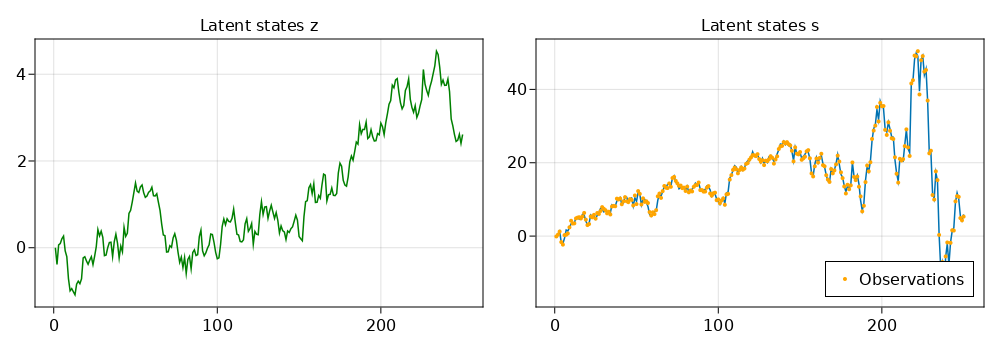

In [73]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states s")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, s)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

In [74]:
import .GCV: ruleMGaussianControlledVarianceGGDDD, ruleMGaussianMeanPrecisionEGD
import .GCV: ruleSVBGaussianControlledVarianceOutNGDDD, ruleSVBGaussianMeanPrecisionMEND
import .GCV: ruleSVBGaussianControlledVarianceXGNDDD, ruleSVBGaussianControlledVarianceZDNDD
import .GCV: ruleSVBGaussianControlledVarianceXGNDDD
import .GCV: GaussianControlledVariance

In [75]:
g = FactorGraph()

model_τ_z = params["τ_z"]
model_τ_y = params["τ_y"]
model_κ = params["κ"]
model_ω = params["ω"]

@RV zv_min_mean
@RV zv_min_prec

placeholder(zv_min_mean, :zv_min_mean)
placeholder(zv_min_prec, :zv_min_prec)

@RV sv_min_mean
@RV sv_min_prec

placeholder(sv_min_mean, :sv_min_mean)
placeholder(sv_min_prec, :sv_min_prec)

@RV zv_min ~ GaussianMeanPrecision(zv_min_mean, zv_min_prec)
@RV sv_min ~ GaussianMeanPrecision(sv_min_mean, sv_min_prec)

@RV zv ~ GaussianMeanPrecision(zv_min, model_τ_z)
@RV sv ~ GaussianControlledVariance(sv_min, zv, model_κ, model_ω)

@RV yv ~ GaussianMeanPrecision(sv, model_τ_y)

placeholder(yv, :yv)

Variable(:yv, Edges:
Edge belonging to variable yv: ( gaussianmeanprecision_4.i[out] )----( placeholder_yv.i[out] ).
)

In [76]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization([ zv, zv_min ], [sv, sv_min], ids=[ :Z, :S ])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

  0.347327 seconds (41.03 k allocations: 21.009 MiB)


freeEnergy (generic function with 1 method)

In [77]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization([ zv, zv_min ], [sv, sv_min], ids=[ :Z, :S ])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

  0.360006 seconds (41.04 k allocations: 21.010 MiB)


freeEnergy (generic function with 1 method)

In [78]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization([ zv, zv_min ], [sv, sv_min], ids=[ :Z, :S ])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

  0.345083 seconds (41.04 k allocations: 21.010 MiB)


freeEnergy (generic function with 1 method)

In [79]:
# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50  - 0.366525 seconds (41.03 k allocations: 21.007 MiB)
# 100 - 0.359312 seconds (41.05 k allocations: 21.009 MiB)
# 250 - 0.345083 seconds (41.04 k allocations: 21.010 MiB)

In [80]:
function inference()     
    nitr = 20
    
    zv_k_mean = 0.0
    zv_k_prec = inv(5.0)
    
    sv_k_mean = 0.0
    sv_k_prec = inv(5.0)
    
    marginals = Dict{Any, Any}(
        :sv_sv_min => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m = [ 0.0, 0.0 ], v = [ 5.0 0.0; 0.0 5.0 ]),
        :zv => ProbabilityDistribution(Univariate, GaussianMeanPrecision, m = zv_k_mean, w = zv_k_prec),
        :sv => ProbabilityDistribution(Univariate, GaussianMeanPrecision, m = sv_k_mean, w = sv_k_prec)
    )
    
    fe = Array{Float64}(undef, length(y), nitr)
    zm = []
    sm = []
    
    for (i, observation) in enumerate(y)
        
        data = Dict(
            :zv_min_mean => zv_k_mean,
            :zv_min_prec => zv_k_prec,
            :sv_min_mean => sv_k_mean,
            :sv_min_prec => sv_k_prec,
            :yv => observation
        )
        
        for j in 1:nitr
            stepS!(data, marginals)
            stepZ!(data, marginals)
            fe[i, j] = freeEnergy(data, marginals)
        end
        
        push!(zm, marginals[:zv])
        push!(sm, marginals[:sv])
        
        zv_k_mean = ForneyLab.unsafeMean(marginals[:zv])
        zv_k_prec = inv(ForneyLab.unsafeVar(marginals[:zv]))
        sv_k_mean = ForneyLab.unsafeMean(marginals[:sv])
        sv_k_prec = inv(ForneyLab.unsafeVar(marginals[:sv]))
    end
    
    return zm, sm, fe
end

inference (generic function with 1 method)

In [81]:
@time inference();

  2.472063 seconds (21.34 M allocations: 1.082 GiB, 5.77% gc time, 10.02% compilation time)


In [82]:
# ForneyLab compilation time
# 50  - 0.774004 seconds (4.60 M allocations: 241.971 MiB, 7.16% gc time, 29.82% compilation time)
# 100 - 1.160789 seconds (8.79 M allocations: 458.590 MiB, 6.73% gc time, 20.99% compilation time)
# 250 - 2.472063 seconds (21.34 M allocations: 1.082 GiB, 5.77% gc time, 10.02% compilation time)

In [83]:
@btime inference();

  2.368 s (20931061 allocations: 1.06 GiB)


In [84]:
# ForneyLab execution times
# 50 - 457.610 ms (4186256 allocations: 216.62 MiB)
# 100 - 876.342 ms (8372458 allocations: 433.24 MiB)
# 250 - 2.368 s (20931061 allocations: 1.06 GiB)

In [85]:
zm, sm, fe = inference();

In [86]:
println("Average MSE Z: $(average_mse(z, zm))")
println("Average MSE S: $(average_mse(s, sm))")

Average MSE Z: 178.50760559398302
Average MSE S: 95.5144671925325


In [87]:
# ForneyLab average MSE Z
# 50  - 45.08470765746846
# 100 - 71.65191980322123
# 250 - 178.50760559398302

In [88]:
# ForneyLab average MSE S
# 50  - 18.77143667983914
# 100 - 37.025891761348944
# 250 - 95.5144671925325

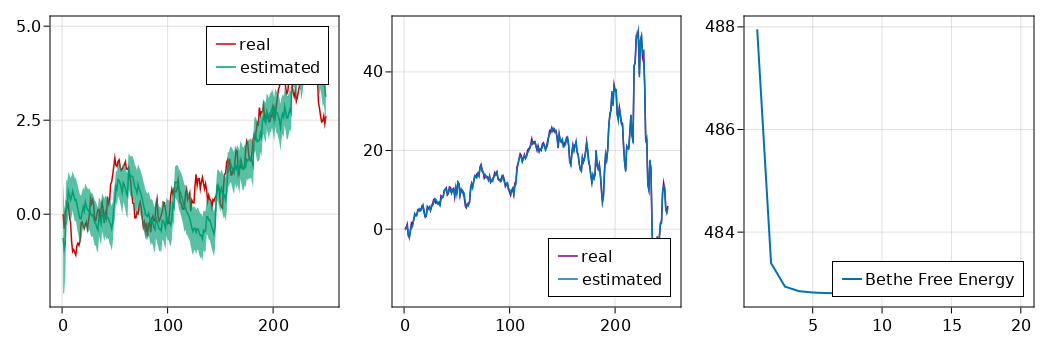

In [89]:
let 
    c = Makie.wong_colors()
    
    @unpack n = params

    f1    = Figure(resolution = (350, 350))
    f2    = Figure(resolution = (350, 350))
    f3    = Figure(resolution = (350, 350))
    grid  = 1:n

    ax1 = Makie.Axis(f1[1, 1])
    ax2 = Makie.Axis(f2[1, 1])
    ax3 = Makie.Axis(f3[1, 1])

    function plot_z(fig)

        lines!(fig, grid, z, color = :red3, label = "real")
        lines!(fig, grid, ForneyLab.unsafeMean.(zm), color = c[3], label = "estimated")
        band!(fig, grid, 
            ForneyLab.unsafeMean.(zm) .- sqrt.(ForneyLab.unsafeVar.(zm)),
            ForneyLab.unsafeMean.(zm) .+ sqrt.(ForneyLab.unsafeVar.(zm)),
            color = (c[3], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rt)
    end

    function plot_s(fig)

        lines!(fig, grid, s, color = :purple, label = "real")
        lines!(fig, grid, ForneyLab.unsafeMean.(sm), color = c[1], label = "estimated")
        band!(fig, grid, 
            ForneyLab.unsafeMean.(sm) .- sqrt.(ForneyLab.unsafeVar.(sm)),
            ForneyLab.unsafeMean.(sm) .+ sqrt.(ForneyLab.unsafeVar.(sm)),
            color = (c[1], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rb)
    end

    local rfe = vec(sum(fe, dims = 1))

    function plot_fe(fig)
        lines!(fig, 1:length(rfe), rfe, linewidth = 2, label = "Bethe Free Energy")
        axislegend(fig, labelsize = 16, position = :rb)
    end

    plot_z(ax1)
    plot_s(ax2)
    plot_fe(ax3)

    @saveplot f1 "hgf_inference_z_fl"
    @saveplot f2 "hgf_inference_s_fl"
    @saveplot f3 "hgf_inference_fe_fl"

    local af = Figure(resolution = (350 * 3, 350))

    plot_z(Makie.Axis(af[1, 1]))
    plot_s(Makie.Axis(af[1, 2]))
    plot_fe(Makie.Axis(af[1, 3]))
    
    # @show average_mse(z, zm[range])
    # @show average_mse(s, sm[range])

    af
end